[View in Colaboratory](https://colab.research.google.com/github/nholmber/cp2k-analysis-tools/blob/master/examples/dos_colab.ipynb)

# Density of States and Electrode Potential

The script `dos.py` contains tools to process the output of a density of states (DOS) calculation from CP2K. An example output file is given in the data directory, which contains the projected DOS of platinum in a 3-frame-long molecular dynamics simulation in water. Note that you can use the script for other codes in addition to CP2K if you implement a suitable parser.  

In addition to DOS-related properties, the script is capable of computing the electrode potential, that is, the relative energy between the Fermi level and a reference point in vacuum. This calculation requires an additional input file which contains the total electrostatic potential of the system averaged in the direction of surface normal vector, possibly sampled from a molecular dynamics simulation. Your system should contain a sufficiently large vacuum region in this direction for meaningful results. You must also use an electrostatic decoupler (e.g. Martyna-Tuckermann Poisson solver) or a dipole correction. For example, if your system contains a 2D periodic surface slab with water on top of it, you need a sufficient amount of vacuum in the nonperiodic ("height") direction, which is also the direction that you should use to average the electrostatic potential.

In CP2K, you could follow the flowchart:
1. Run MD simulation of system saving wavefunction and other restart files every $N$ step. 
2. Sample [DOS](https://manual.cp2k.org/trunk/CP2K_INPUT/FORCE_EVAL/DFT/PRINT/PDOS.html) and [electrostatic potential](https://manual.cp2k.org/trunk/CP2K_INPUT/FORCE_EVAL/DFT/PRINT/V_HARTREE_CUBE.html) every $X$ step using restart files. Remember to use a [dipole correction](https://manual.cp2k.org/trunk/CP2K_INPUT/FORCE_EVAL/DFT.html#SURFACE_DIPOLE_CORRECTION) or an [electrostatic decoupler](https://manual.cp2k.org/trunk/CP2K_INPUT/FORCE_EVAL/DFT/POISSON.html).
3. Use the [cubecruncher](https://www.cp2k.org/tools:cubecruncher) utility that is included in the CP2K tools folder to average the cube files.
4. Concatenate DOS and averaged potential files into two files (one per property). 
5. Use files as input to the `dos.py` script.


## List of Features
* Compute total projected DOS
* Smear DOS with Gaussian
* Determine HOMO/LUMO levels
* Compute electrode potential on absolute and standard hydrogen electrode scales
* Determine vacuum potential dynamically or statically

## Walkthrough Example

In this example, we will sample the properties of a Pt-water interface from a molecular dynamics simulation. Only three randomly sampled frames from this simulation are included to keep the analysis time short.


## Setup Google Colab Environment

In [1]:
!git clone https://github.com/nholmber/cp2k-analysis-tools

Cloning into 'cp2k-analysis-tools'...
remote: Counting objects: 40, done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 40 (delta 10), reused 31 (delta 5), pack-reused 0
Unpacking objects: 100% (40/40), done.


In [2]:
%cd /content/cp2k-analysis-tools/examples/

/content/cp2k-analysis-tools/examples


## Setup Notebook Environment

In [0]:
# Setup Python environment
import numpy as np

# Configure matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Add files to path
import sys
sys.path.append('../src/')
from dos import DOS

# Notebook magic
%load_ext autoreload
%autoreload 2

## Load Input Files

In [4]:
# Read DOS file
t0 = 10 # Arbitrary initial timestep
stride = 100 # Data stride (e.g. number of MD steps between data samples)
dos_file = 'data/dos-3frames.dat'
dos = DOS()
dos.read_dos(dos_file, [t0, stride])

print(f'Read DOS file with {len(dos.dos)} frames.')

# Add averaged electrostatic potential to object
potential_file = 'data/elpot-3frames.dat'
dos.read_potential(potential_file)
nframes = len(dos.get_property('potential', 'all'))
print(f'Read potential file with {nframes} frames.')

Read DOS file with 3 frames.
Read potential file with 3 frames.


## Inspect the Data

In [5]:
# Let's see what information was stored for the first MD frame 
for (frame, obj) in dos.dos.items():
    print(frame, type(obj), obj.__dict__)
    break

10.0 <class 'dos.DOSFrame'> {'_dos': array([[-9.82842803e+01,  2.00000000e+00,  8.42434540e-01, ...,
         1.51751300e-02,  2.09949000e-03,  3.07856500e-02],
       [-9.82250956e+01,  2.00000000e+00,  8.44522930e-01, ...,
         1.62022000e-02,  3.02975000e-03,  3.02164100e-02],
       [-9.81891493e+01,  2.00000000e+00,  8.45667560e-01, ...,
         1.59510500e-02,  2.46642000e-03,  3.07579500e-02],
       ...,
       [ 1.57636145e+02,  0.00000000e+00,  1.00000000e-08, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.58624789e+02,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.59354680e+02,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]), '_fermi': -0.01278935041258146, '_potential': array([[ 0.00000000e+00,  5.84442956e+00],
       [ 1.64983160e-01,  5.84441820e+00],
       [ 3.29966320e-01,  5.84441022e+00],
       [ 4.94949480e-01,  5.84

Use dedicated function to extract properties

In [6]:
# We can extract a specific property with the get_property function
frame = 10
fermi_level = dos.get_property('fermi', frame)
print(f"Fermi level was {fermi_level:.6f} eV at frame {frame}.")

# Let's get the Fermi level at all MD steps
print('-'*40)
fermi_levels = dos.get_property('fermi', 'all')
frames = dos.dos.keys()

for frame, fermi_level in zip(frames, fermi_levels):
    print(f"Fermi level was {fermi_level:+.6f} eV at frame {frame:5.1f}.")
    
# Let's see what happens if we try to access an invalid property
print('-'*40)
try:
    dos.get_property('foo', frame)
except ValueError as err:
    print(err)

Fermi level was -0.012789 eV at frame 10.
----------------------------------------
Fermi level was -0.012789 eV at frame  10.0.
Fermi level was +0.090478 eV at frame 110.0.
Fermi level was +0.103539 eV at frame 210.0.
----------------------------------------
Tried to get invalid property foo. Available properties ['dos', 'eigenvalues', 'fermi', 'homo', 'lumo', 'potential', 'smear', 'tpdos', 'vacuum', 'voltage'].


## Computing New Properties

In [7]:
# We can compute new properties using the evaluate function
# Let's compute the total projected DOS

# Test invalid method name first 
try:
    dos.evaluate('tpdos', 'all')
except ValueError as err:
    print(err)
    
# We should have used 'calculate_tpdos', let's try that next
print('-'*40)
print('Calculating TPDOS')
dos.evaluate('calculate_tpdos', 'all')
print(dos.get_property('tpdos', 10))

# All properties with a getter have a corresponding setter e.g. if you want to copy data
# Note that you should generally avoid calling the setters and use the evaluate method instead 
print('-'*40)
print('Setting vacuum potential')
frame = 10
print(dos.get_property('vacuum', frame))
dos.set_property('vacuum', np.array([0, 0]), frame)
print(dos.get_property('vacuum', frame))

Function tpdos is not a callable function of type DOSFrame. Accepted functions: ['calculate_homo_lumo', 'calculate_tpdos', 'calculate_vacuum', 'calculate_voltage', 'get_voltage', 'smear_dos'].
----------------------------------------
Calculating TPDOS
[[-9.82842803e+01  9.59619210e-01]
 [-9.82250956e+01  9.64620930e-01]
 [-9.81891493e+01  9.64368230e-01]
 ...
 [ 1.57636145e+02  3.00000000e-08]
 [ 1.58624789e+02  0.00000000e+00]
 [ 1.59354680e+02  0.00000000e+00]]
----------------------------------------
Setting vacuum potential
None
[0 0]


## Visualizing the Data

Let's plot the averaged electrostatic potential first 

In [8]:
frames = list(dos.dos.keys())
potentials = dos.get_property('potential', 'all')
x = potentials[0][:, 0]
print(f"Trajectory has {len(potentials)} frames with stride 1.")

Trajectory has 3 frames with stride 1.


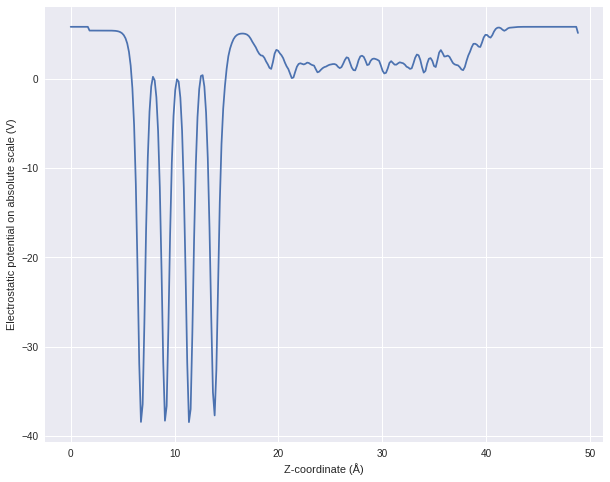

In [21]:
#@title After running this cell manually, the figure will refresh when you move the slider. { run: "auto" }

# Note that the we cannot pass Python objects to the slider and it must adjust manually
Frame = 0 #@param {type:"slider", min:0, max:2, step:1}

fig = plt.figure(3, figsize=(10,8))
lines = plt.plot(x, potentials[Frame][:, 1])
# Labels
plt.xlabel("Z-coordinate (Å)")
plt.ylabel("Electrostatic potential on absolute scale (V)")
plt.show()


### Computing the Electrode Potential

We can compute the system's electrode potential on an absolute scale as[$^\mathrm{ref\ 1}$](https://dx.doi.org/10.1039/C2CP41652B)

$$
U^\mathrm{abs.} = -\frac{\mu}{e}+\phi^S
$$
where is $\mu$ is the system's Fermi level, the $\phi^S$ is the vacuum potential, and $e$ is the elementary charge.

In this example, our system is composed of
* 4-layer Pt surface (visible in plot above at around 10 Å)
* water (between 20-40 Å)
* vacuum above/below the surface+water system


The electrostatic potential flattens to a constant value above and below the surface system. This value is not constant on both sides of the system because the system has a net dipole moment. A dipole correction has been applied to compensate for this fact, which you can see as the step-like discontinuity in the value of the potential inside the vacuum region. The discontinuity's location changes from one MD frame to another. 

To compute the electrode potential, we need to calculate the vacuum potential $\phi^S$. This is simply the value of the electrostatic potential above water inside the vacuum region before the dipole correction induced jump in potential. We cannot set the vacuum potential to a fixed point along the Z-axis because of the dipole correction. We can instead use a method that finds the vacuum potential dynamically using a set of heuristic rules (see function `_find_vacuum_potential()` in `dos.py` for details).

In [0]:
# Compute vacuum potential
vacuum_loc = -1. # Negative number means detect automatically
dos.evaluate('calculate_vacuum', 'all', vacuum_loc)
vacuum_potentials = dos.get_property('vacuum', 'all')

# Get electrostatic potential 
frames = list(dos.dos.keys())
potentials = dos.get_property('potential', 'all')
x = potentials[0][:, 0]

Replot electrostatic potential and add vacuum potential to same figure 

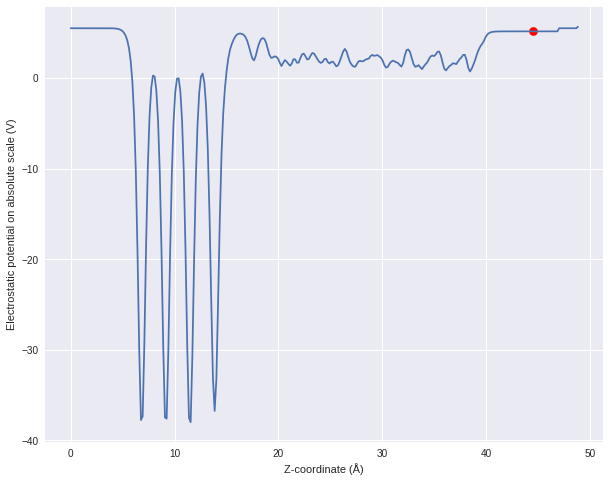

In [29]:
#@title After running this cell manually, the figure will refresh when you move the slider. { run: "auto" }

# Note that the we cannot pass Python objects to the slider and it must adjust manually
Frame = 1 #@param {type:"slider", min:0, max:2, step:1}

fig = plt.figure(4, figsize=(10,8))
lines = plt.plot(x, potentials[Frame][:, 1])
scatter = plt.scatter(*vacuum_potentials[Frame], marker='o', color='r', s=70)

# Labels
plt.xlabel("Z-coordinate (Å)")
plt.ylabel("Electrostatic potential on absolute scale (V)")
plt.show()

### Conversion to SHE Scale

We now have everything that we need to evaluate the electrode potential on the absolute potential scale. We can convert the value to the so-called standard hydrogen electrode (SHE) scale according to

$$
U^\mathrm{SHE} = U^\mathrm{abs.} + U^\mathrm{abs.\ SHE}
$$

where the last term is the absolute electrode potential of SHE, -4.44 V.

In [30]:
electrode_potentials = dos.get_property('voltage', 'all')

frames = dos.dos.keys()

for frame, pot in zip(frames, electrode_potentials):
    abs_pot, rel_pot = pot
    print(f"Electrode potential was {abs_pot:+.2f} V (absolute scale), or {rel_pot:+.2f} V relative to SHE, at frame {frame:5.1f}.")


Electrode potential was +5.86 V (absolute scale), or +1.42 V relative to SHE, at frame  10.0.
Electrode potential was +5.10 V (absolute scale), or +0.66 V relative to SHE, at frame 110.0.
Electrode potential was +5.00 V (absolute scale), or +0.56 V relative to SHE, at frame 210.0.


## Gaussian smeared DOS

The raw data from a DOS calculation is discrete spectrum of (eigenvalue, orbital weight) pairs. DOS data is commonly smeared with Gaussians prior to plotting. 

The function `smear_dos` smears the total projected DOS, which we computed further above. The function takes as input the width of the Gaussian that is used for smearing.

In [0]:
# Feel free vary the width of the Gaussian and see what happens to the plot
gaussian_width = 0.05
dos.evaluate('smear_dos', 'all', gaussian_width)

In [0]:
# Get the smeared DOS
frames = list(dos.dos.keys())
smeared_dos = dos.get_property('smear', 'all')
# Get the electron energies i.e. x-axis of the DOS plot (constant object)
eigenvalues = dos.get_property('smear', frames[0])

Plot smeared DOS

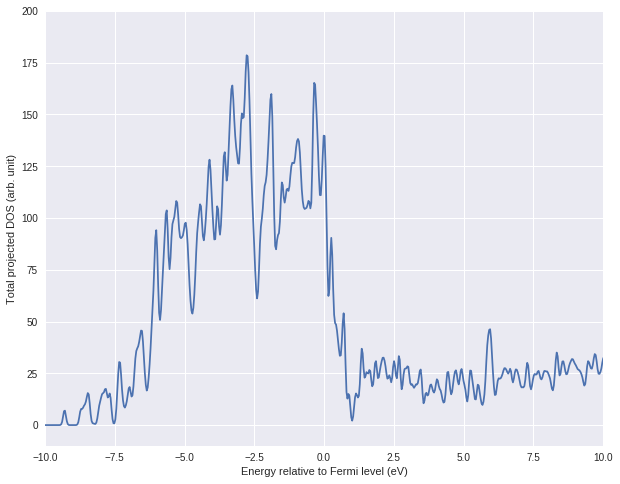

In [34]:
#@title After running this cell manually, the figure will refresh when you move the slider. { run: "auto" }

# Note that the we cannot pass Python objects to the slider and it must adjust manually
Frame = 2 #@param {type:"slider", min:0, max:2, step:1}

fig = plt.figure(5, figsize=(10,8))
lines = plt.plot(smeared_dos[Frame][:, 0], smeared_dos[Frame][:, 1])

# Focus on region around Fermi level
plt.xlim([-10, 10])
plt.ylim([-10, 200])

# Labels
plt.xlabel("Energy relative to Fermi level (eV)")
plt.ylabel("Total projected DOS (arb. unit)")

plt.show()

### Smearing Specific Orbitals

Above, we smeared the total projected DOS. Sometimes it might useful to decompose this figure into contributions, e.g., to visualize specific d-orbitals separately. You can use the `smear` and `delta` functions as templates to smear just a subset of orbitals. 

In this example, we will construct a plot for the $d_{z^2}$ orbitals.

Get orbital projected DOS 

In [35]:
# Let's check what kind of orbitals we have in our data set
with open('data/dos-3frames.dat') as fp:
    fp.readline()
    header = fp.readline()

orbitals = header.split('Occupation')[-1].strip().split()
print(f'List of orbitals: {orbitals}')

# Extract DOS for d0 orbitals (i.e. d_z2 orbitals)
orbital_idx = orbitals.index('d0')
dos_list = dos.get_property('dos', 'all')

# Pick these columns from the DOS 
# The first col is the energy eigenvalue, second the occupation, followed by the orbitals 
cols = [0, orbital_idx+2]

dz_dos = []
for frame in dos_list:
    dz_dos.append(frame[:, cols])

List of orbitals: ['s', 'py', 'pz', 'px', 'd-2', 'd-1', 'd0', 'd+1', 'd+2', 'f-3', 'f-2', 'f-1', 'f0', 'f+1', 'f+2', 'f+3']


Apply smearing

In [0]:
# Smear d0 orbital DOS
from dos import delta

gaussian_width = 0.05
dz_smeared = []

for frame in dz_dos:
    emin, emax = np.amin(frame[:, 0]), np.amax(frame[:, 0])
    eigenvalues = np.linspace(emin, emax, len(frame[:,0]))
    
    smeared = np.zeros(frame.shape)
    # Eigenvalues
    smeared[:, 0] = frame[:, 0]
    
    for e, pd in frame:
        smeared[:, 1] += pd*delta(eigenvalues, e, gaussian_width)
        
    dz_smeared.append(smeared)


Plot orbital projected DOS

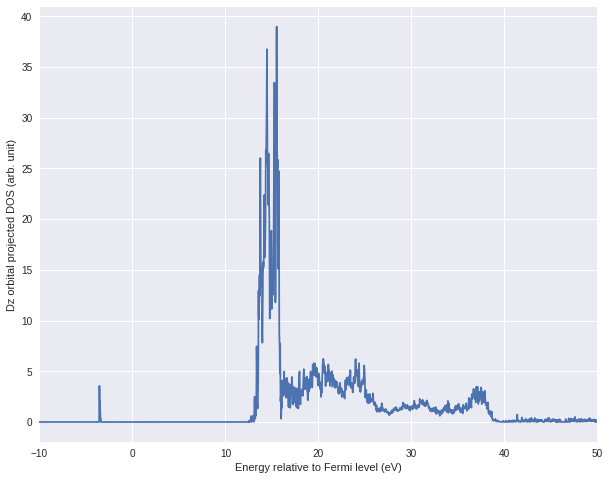

In [38]:
#@title After running this cell manually, the figure will refresh when you move the slider. { run: "auto" }

# Note that the we cannot pass Python objects to the slider and it must adjust manually
Frame = 2 #@param {type:"slider", min:0, max:2, step:1}

frames = list(dos.dos.keys())
smeared_dos = dz_smeared

fig = plt.figure(7, figsize=(10,8))
lines = plt.plot(smeared_dos[Frame][:, 0], smeared_dos[Frame][:, 1])

# Focus on region around Fermi level
plt.xlim([-10, 50])

# Labels
plt.xlabel("Energy relative to Fermi level (eV)")
plt.ylabel("Dz orbital projected DOS (arb. unit)")

plt.show()